In [1]:
from fastai import *
from torch.nn import init
from fastai.callbacks import *
from fastai.tabular import *

In [2]:
PATH = "data/house"

In [3]:
df = pd.read_csv(f'{PATH}/train.csv')
df_test = pd.read_csv(f'{PATH}/test.csv')

In [8]:
print(df[:10])

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   
5   6          50       RL         85.0    14115   Pave   NaN      IR1   
6   7          20       RL         75.0    10084   Pave   NaN      Reg   
7   8          60       RL          NaN    10382   Pave   NaN      IR1   
8   9          50       RM         51.0     6120   Pave   NaN      Reg   
9  10         190       RL         50.0     7420   Pave   NaN      Reg   

  LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1         Lvl    AllPub  ...       

In [9]:
df.SalePrice

0       208500
1       181500
2       223500
3       140000
4       250000
5       143000
6       307000
7       200000
8       129900
9       118000
10      129500
11      345000
12      144000
13      279500
14      157000
15      132000
16      149000
17       90000
18      159000
19      139000
20      325300
21      139400
22      230000
23      129900
24      154000
25      256300
26      134800
27      306000
28      207500
29       68500
         ...  
1430    192140
1431    143750
1432     64500
1433    186500
1434    160000
1435    174000
1436    120500
1437    394617
1438    149700
1439    197000
1440    191000
1441    149300
1442    310000
1443    121000
1444    179600
1445    129000
1446    157900
1447    240000
1448    112000
1449     92000
1450    136000
1451    287090
1452    145000
1453     84500
1454    185000
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [4]:
# feature engineering
df['totalSF'] = df['1stFlrSF'] + df['2ndFlrSF']
df_test['totalSF'] = df_test['1stFlrSF'] + df_test['2ndFlrSF']

df['TotalBath'] = df['FullBath'] + df['HalfBath']
df['TotalBsmtBath'] = df['BsmtFullBath'] + df['BsmtHalfBath']
df['garageAge'] = df['YrSold'] - df['GarageYrBlt']
df['remodAge'] = df['YrSold'] - df['YearRemodAdd']


df_test['TotalBath'] = df_test['FullBath'] + df_test['HalfBath']
df_test['TotalBsmtBath'] = df_test['BsmtFullBath'] + df_test['BsmtHalfBath']
df_test['garageAge'] = df_test['YrSold'] - df_test['GarageYrBlt']
df_test['remodAge'] = df_test['YrSold'] - df_test['YearRemodAdd']


df['age'] = df['YrSold'] - df['YearBuilt']
df_test['age'] = df['YrSold'] - df['YearBuilt']

season_dict = { 1 : 3, 2 : 3, 3 : 0, 4 : 0, 5 : 0, 6 : 1, 7 : 1, 8 : 1, 9 : 2, 10 : 2, 11 : 2, 12 : 3}
holiday_dict = { 1 : 1, 2 : 1, 3 : 0, 4 : 1, 5 : 2, 6 : 1, 7 : 1, 8 : 0, 9 : 1, 10 : 1, 11 : 3, 12 : 1}
df['holidays'] = 0
df['season'] = 0
for i in range(len(df)):    
    df.at[i, 'holidays'] = holiday_dict[df.loc[i]['MoSold']]
    df.at[i, 'season'] = season_dict[df.loc[i]['MoSold']]    

    
df_test['holidays'] = 0
df_test['season'] = 0
for i in range(len(df_test)):    
    df_test.at[i, 'season'] = season_dict[df_test.loc[i]['MoSold']]    
    df_test.at[i, 'holidays'] = holiday_dict[df_test.loc[i]['MoSold']]    
    
prop_id = df_test.Id.values  
df.drop(['Id'], axis=1, inplace=True)
df_test.drop(columns=['Id'], inplace=True)

df.drop(['Utilities'], axis=1, inplace=True)
df_test.drop(columns=['Utilities'], inplace=True)

df.drop(['YrSold'], axis=1, inplace=True)
df_test.drop(columns=['YrSold'], inplace=True)

df.drop(['YearBuilt'], axis=1, inplace=True)
df_test.drop(columns=['YearBuilt'], inplace=True)

df.drop(['YearRemodAdd'], axis=1, inplace=True)
df_test.drop(columns=['YearRemodAdd'], inplace=True)


In [5]:
# use_cols = ['OverallQual',
#  'totalSF',
#  'GarageCars',
#  'GrLivArea',
#  'TotalBsmtSF',
#  'ExterQual',
#  'age',
#  'BsmtFinSF1',
#  '1stFlrSF',
#  'GarageArea',
#  'LotArea',
#  'KitchenQual',
#  'FullBath',
#  'TotRmsAbvGrd',
#  'remodAge',
#  '2ndFlrSF',
#  'MoSold',
#  'MasVnrArea',
#  'GarageYrBlt',
#  'TotalBath',
#  'BsmtQual',
#  'Neighborhood',
#  'Fireplaces',
#  'WoodDeckSF',
#  'CentralAir',
#  'LotFrontage',
#  'BsmtUnfSF',
#  'OpenPorchSF',
#  'FireplaceQu',
#  'garageAge',
#  'GarageType',
#  'LotShape',
#  'BedroomAbvGr',
#  'MSZoning',
#  'MSSubClass',
#  'Exterior1st',
#  'OverallCond',
#  'TotalBsmtBath',
# 'SalePrice',
#  'BsmtExposure']

In [6]:
cat_names = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass', 'OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'season', 'holidays', 'TotalBath', 'TotalBsmtBath', 'garageAge', 'remodAge']
cont_names = [ 'totalSF', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

# cat_names = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold', 'season', 'holidays']
# cont_names = [ 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

In [ ]:
# cat_names = list(set(cat_names).intersection(set(use_cols)))
# cont_names = list(set(cont_names).intersection(set(use_cols)))

In [ ]:
# df = df[use_cols]
# df_test = df_test[set(use_cols) - set(['SalePrice'])]

In [ ]:
# imp_cols = []
# for c in df.columns:
#     if  df[c].isnull().value_counts()[0] == len(df):
#         imp_cols.append(c)
#         #print("column has no nan ", c)
# drop_names = set(df.columns) - set(imp_cols)
# for c in drop_names:
#     df.drop(c, inplace=True, axis=1)
#     df_test.drop(c, inplace=True, axis=1) 
# cat_names = list(set(cat_names) - set(drop_names))
# cont_names = list(set(cont_names) - set(drop_names))

In [ ]:
prop_id

In [7]:
x, y = {}, {}
nan_values = {}
for c in df.columns:
    if c != "SalePrice":
        x[c] = df[c].isnull().value_counts()[0]
        y[c] = df_test[c].isnull().value_counts()[0]
        if x[c] == len(df):
            if y[c] != len(df_test):
                #print("Nan columns found in test_set ", c , " count ", y[c], " type ", df_test[c].dtype)
                nan_values[c] = 0.0
        #print("column train ", c, df[c].isnull().value_counts()[0]/len(df), " test  ", df_test[c].isnull().value_counts()[0]/len(df))
# sorted_x = sorted(x.items(), key=operator.itemgetter(1))
# sorted_y = sorted(y.items(), key=operator.itemgetter(1))
# print("Training Set")
# for k, v in (sorted_x):
#     print(k, " ", v)

# print("\n\nTest Set")
# for k, v in (sorted_y):
#     print(k, " ", v)


# fill na values
df_test.fillna(value=nan_values, inplace=True)

In [8]:
for c in cat_names:        
    df[c] = df[c].apply(str, convert_dtype=True)
    df_test[c] = df_test[c].apply(str, convert_dtype=True)

In [9]:
df.SalePrice = np.log(df.SalePrice)

In [10]:
dep_var = 'SalePrice'
procs = [FillMissing, Categorify, Normalize]

In [11]:
TARGET_PATH = PATH

In [ ]:
#test = TabularList.from_df(df_test, path=TARGET_PATH, cat_names=cat_names)

In [12]:
test_data = TabularList.from_df(df_test, path=PATH, cat_names=cat_names, cont_names=cont_names)
data = (TabularList.from_df(df, path=TARGET_PATH, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_subsets(train_size=0.8, valid_size=0.2)
                           .label_from_df(cols=dep_var, label_cls=FloatList)            
                           .add_test(test_data, 0)
                           .databunch(bs=1168))


In [ ]:
# class MyRelu(nn.Module):
#     def __init__(self, leak=None, sub=None, maxv=None):
#         super().__init__()
#         self.leak,self.sub,self.maxv = leak,sub,maxv

#     def forward(self, x):
#         neg = False
#         if (x > 0).sum() < 0:
#             neg = True
#             x = -x
#         x = F.relu(x)
#         x = x.clamp_min_(-self.maxv)
#         x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
#         if self.sub is not None: x.sub_(self.sub)
#         if self.maxv is not None: x.clamp_max_(self.maxv)
#         if neg:
#             x = -x
#         return x

In [ ]:
#emb_szs = [(6, 4), (3, 3), (4, 3), (5, 4), (5, 4), (2, 2), (6, 4), (4, 3), (26, 10), (10, 6), (7, 5), (6, 4), (9, 5), (7, 5), (9, 5), (15, 7), (17, 8), (6, 4), (5, 4), (6, 4), (7, 5), (6, 4), (6, 4), (6, 4), (8, 5), (8, 5), (7, 5), (5, 4), (3, 3), (7, 5), (5, 4), (7, 5), (7, 5), (8, 5), (5, 4), (7, 5), (7, 5), (4, 3), (5, 4), (6, 4), (6, 4), (9, 5), (7, 5), (16, 8), (11, 6), (10, 6), (111, 22), (62, 16), (5, 4), (4, 3), (5, 4), (4, 3), (9, 5), (5, 4), (12, 6), (5, 4), (99, 21), (6, 4), (13, 7), (6, 4), (3, 3), (3, 3)]


In [ ]:
# model = TabularModel(emb_szs, len(data.cont_names), out_sz=data.c, layers=[1000,200], ps=None, emb_drop=0.25,
#                      y_range=[11, 14], use_bn=False)
# learn = Learner(data, model, metrics=[RMSE(),], wd=0.1)
# learn.loss_fn = F.mse_loss

In [32]:
learn = tabular_learner(data, layers=[700, 400, 150,100, 75, 25], y_range=[10.5, 13.5], use_bn=True)
# new_layers = nn.Sequential(
#     nn.Linear(in_features=learn.model.layers[0].in_features, out_features=1000, bias=False), 
#     #MyRelu(0.3, 0.5, 5.0),
#     nn.LeakyReLU(0.1),
#     #nn.BatchNorm1d(700, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#     nn.Linear(in_features=1000, out_features=100, bias=False),
#     #MyRelu(0.1, 0.5, 5.0),
#     nn.LeakyReLU(0.1),    
# #     nn.ReLU(),    
#     #nn.BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#     nn.Linear(in_features=100, out_features=1, bias=False)    
# )
# learn.model.layers = new_layers
learn.loss_fn = F.mse_loss
learn.metrics = [RMSE(),]

for l in learn.model.modules():
    if isinstance(l, nn.Linear):
        init.kaiming_normal_(l.weight, a=0.1)

In [34]:
#learn.fit_one_cycle(1, 0.01, callbacks=[ActivationStats(learn), SaveModelCallback(learn)])
#learn.fit_one_cycle(cyc_len=8, max_lr=[0.1,], callbacks=[ActivationStats(learn), SaveModelCallback(learn)])
learn.fit_one_cycle(40, 0.01, callbacks=[ActivationStats(learn), SaveModelCallback(learn)])
#learn.fit_one_cycle(cyc_len=24, max_lr=[0.001,], callbacks=[ActivationStats(learn), SaveModelCallback(learn)])

epoch,train_loss,valid_loss,rmse,time
0,0.000762,0.016747,0.129410,00:00
1,0.000761,0.016616,0.128903,00:00
2,0.000759,0.016519,0.128526,00:00
3,0.000758,0.016444,0.128232,00:00
4,0.000754,0.016389,0.128020,00:00
5,0.000750,0.016342,0.127835,00:00
6,0.000744,0.016298,0.127664,00:00
7,0.000736,0.016257,0.127504,00:00
8,0.000727,0.016222,0.127364,00:00
9,0.000716,0.016197,0.127268,00:00


Better model found at epoch 0 with val_loss value: 0.016746841371059418.
Better model found at epoch 1 with val_loss value: 0.01661604270339012.
Better model found at epoch 2 with val_loss value: 0.016518857330083847.
Better model found at epoch 3 with val_loss value: 0.016443565487861633.
Better model found at epoch 4 with val_loss value: 0.016389036551117897.
Better model found at epoch 5 with val_loss value: 0.01634177565574646.
Better model found at epoch 6 with val_loss value: 0.016297992318868637.
Better model found at epoch 7 with val_loss value: 0.01625729538500309.
Better model found at epoch 8 with val_loss value: 0.01622156798839569.
Better model found at epoch 9 with val_loss value: 0.016197210177779198.
Better model found at epoch 10 with val_loss value: 0.0161886028945446.


In [ ]:
#learn.fit_one_cycle(100, 0.01, callbacks=[actStats, saveModelCallback])

In [26]:
next(iter(data.train_dl))[0][1].shape

torch.Size([1168, 20])

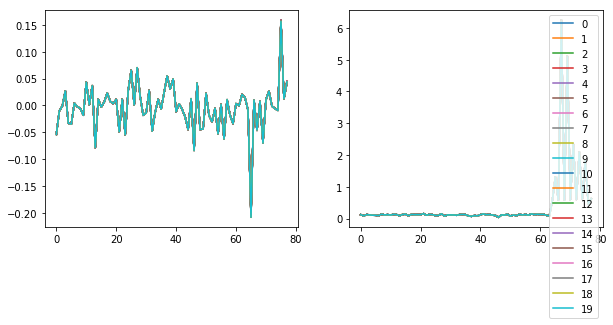

In [35]:
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
ms,ss = learn.activation_stats.stats
# ax0.plot(ms[0:10])
# ax1.plot(ss[0:10])

ax0.plot(ms)
ax1.plot(ss)

plt.legend(range(20));

In [29]:
ss.shape

torch.Size([68, 40])

In [ ]:
from exp.nb_07a import *

In [ ]:
def append_stat(hook, mod, inp, outp):
    d = outp.data
    hook.mean,hook.std = d.mean().item(),d.std().item()

In [ ]:
class Hook1():
    def __init__(self, m, f): 
        self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [ ]:
def lsuv_module(m):
    h = Hook1(m, append_stat)

    while learn.model(*next(iter(data.train_dl))[0]) is not None and abs(h.mean)  > 1e-3: 
        m.bias.data -= h.mean
    while learn.model(*next(iter(data.train_dl))[0]) is not None and abs(h.std-1) > 1e-3: 
        m.weight.data /= h.std

    h.remove()
    return h.mean,h.std

In [ ]:
lsuv_module(learn.model.layers[0])

In [ ]:
lsuv_module(learn.model.layers[2])

In [22]:
pred_val = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
# err = {}
# for i in range(1168, 1460):   
#     err[abs(df.loc[i].SalePrice - pred_val[0][1168-i]).item()] = (df.loc[i], np.exp(pred_val[0][1168-i].item()), np.exp(df.loc[i].SalePrice))
# sorted_err = sorted(err.items(), key=operator.itemgetter(0), reverse=True)
# sorted_err

In [23]:
df_output = pd.DataFrame( {'Id' : prop_id, 'SalePrice' : [np.exp(v.item()) for v in pred_val[0]]})

In [24]:
df_output.to_csv("submission.csv", index=False)